# Germany New Heavy Vehicle Registrations Plots

In Germany, the Kraftfahrtbundesamt (KBA) publishes monthly numbers on alternative fuel usage by vehicle type in their FZ 28 publication:

Neuzulassungen von Kraftfahrzeugen mit alternativem Antrieb  
https://www.kba.de/DE/Statistik/Produktkatalog/produkte/Fahrzeuge/fz28/fz28_gentab.html

Because I was interested in how the electrification develops in the German truck market, here the data for those segments are plotted over time.  
The plots should be updated automatically once new data is released if everything works :)

### Related links and dashboards

- https://www.now-gmbh.de/datenfinder/neuzulassungen-bestand-leichter-mittlerer-und-schwerer-nutzfahrzeuge/  
  Neuzulassungs- und Bestanddashboard der NOW GmbH; Unterteilt nach Gewichtsklasse, jedoch nicht LKW und Sattelzugmaschinen
  - https://www.klimafreundliche-nutzfahrzeuge.de/wissen/marktentwicklung/  
    Das gleiche Dashboard auf der Seite www.klimafreundliche-nutzfahrzeuge.de
  - https://www.now-gmbh.de/datenfinder/neuzulassungen-bestand-pkw-lkw-bus/  
    Erweiterte Statistiken
- https://theicct.org/publication/r2z-eu-hdv-market-development-quarterly-january-june-2025-sept25/  
  The quarterly publications by the ICCT on the state of the European heavy duty electric vehicle market
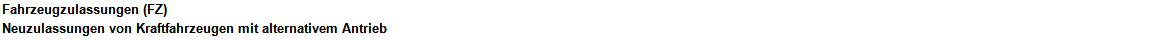

In [1]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import de_kba_datagrabber as kba
from utils import PowerType
from plot_utils import draw_pie

In [2]:
kba.ensure_up_to_date()
ev_data = kba.fz28_1_aggregated()

## Comparison of BEV Share over time

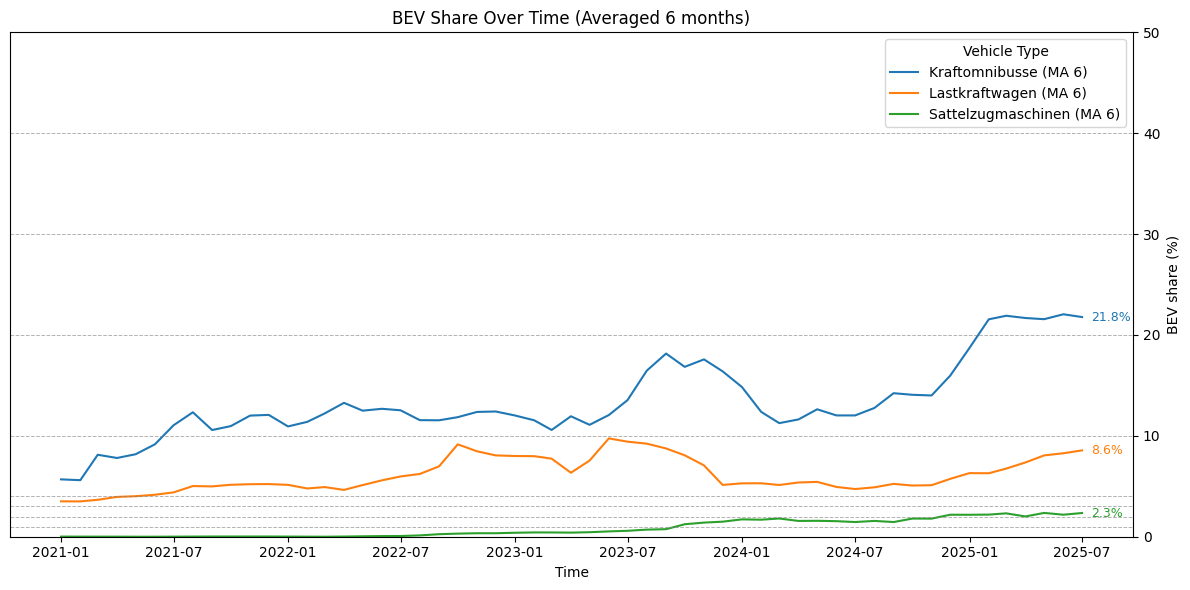

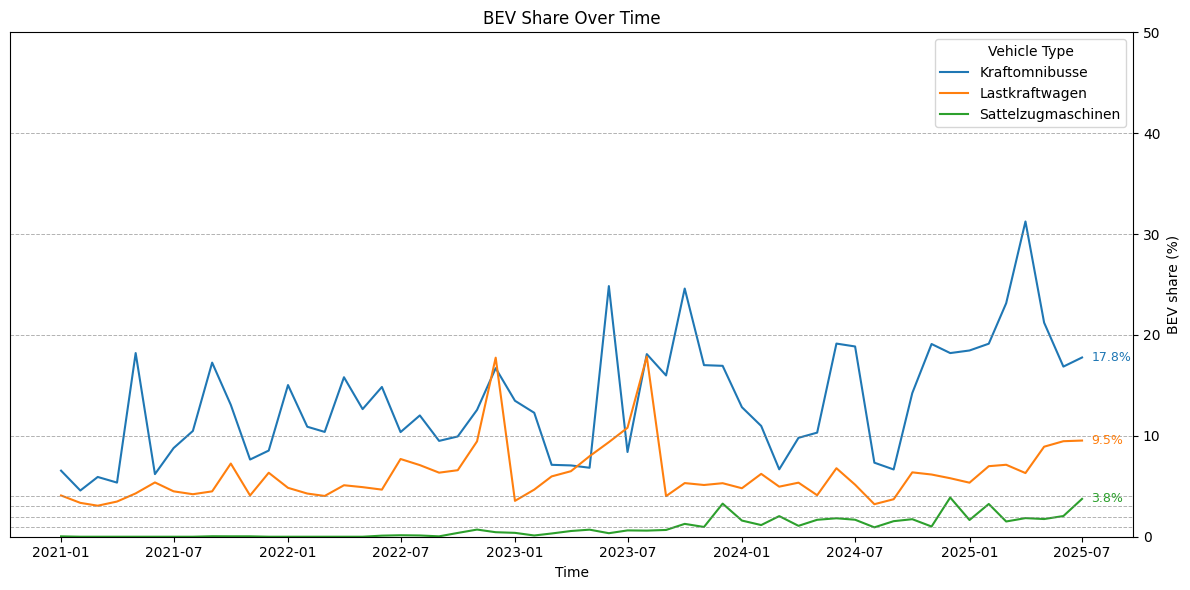

In [3]:
monthy_average_window = 6
types = ['Kraftomnibusse', 'Lastkraftwagen', 'Sattelzugmaschinen']


def plot_bev_share(types, ma_window=1):
    fig, ax = plt.subplots(figsize=(12, 6))
    for t in types:
        sub = ev_data.xs(t, axis=1, level=0, drop_level=True).sort_index()
        total = pd.to_numeric(sub.sum(axis=1), errors='coerce').astype('float64')
        bev = sub[PowerType.BEV] if PowerType.BEV in sub.columns else pd.Series(0, index=sub.index, dtype='float64')
        bev = pd.to_numeric(bev, errors='coerce').astype('float64')
        share_pct = bev.div(total.where(total > 0)).fillna(0.0) * 100

        if ma_window <= 1:
            series_to_plot = share_pct
            label = f'{t}'
        else:
            series_to_plot = share_pct.rolling(window=ma_window, min_periods=1, center=True).mean()
            label = f'{t} (MA {ma_window})'

        # Plot line and add last value label
        line, = ax.plot(series_to_plot.index, series_to_plot.values, label=label)
        valid_series = series_to_plot.dropna()
        if not valid_series.empty:
            x_last = valid_series.index[-1]
            y_last = float(valid_series.iloc[-1])
            # Place the label slightly to the right of the last point
            try:
                x_text = x_last + pd.Timedelta(days=15)
            except Exception:
                x_text = x_last
            ax.text(x_text, y_last, f'{y_last:.1f}%', color=line.get_color(), ha='left', va='center', fontsize=9)

    ax.set_ylim(0, 50)
    # Add horizontal reference lines every 10 percentage points
    for y in range(10, 50, 10):
        ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
    for y in range(1, 5, 1):
        ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7, alpha=0.6)

    ax.set_ylabel('BEV share (%)')
    ax.set_xlabel('Time')
    ax.set_title('BEV Share Over Time' if ma_window <= 1 else f'BEV Share Over Time (Averaged {ma_window} months)')
    ax.legend(title='Vehicle Type')

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    plt.tight_layout()
    plt.show()


plot_bev_share(types, monthy_average_window)
plot_bev_share(types)


## Share of Power Types for LKW (Rigid Trucks) and Sattelzugmaschinen (Tractor-Trailer)

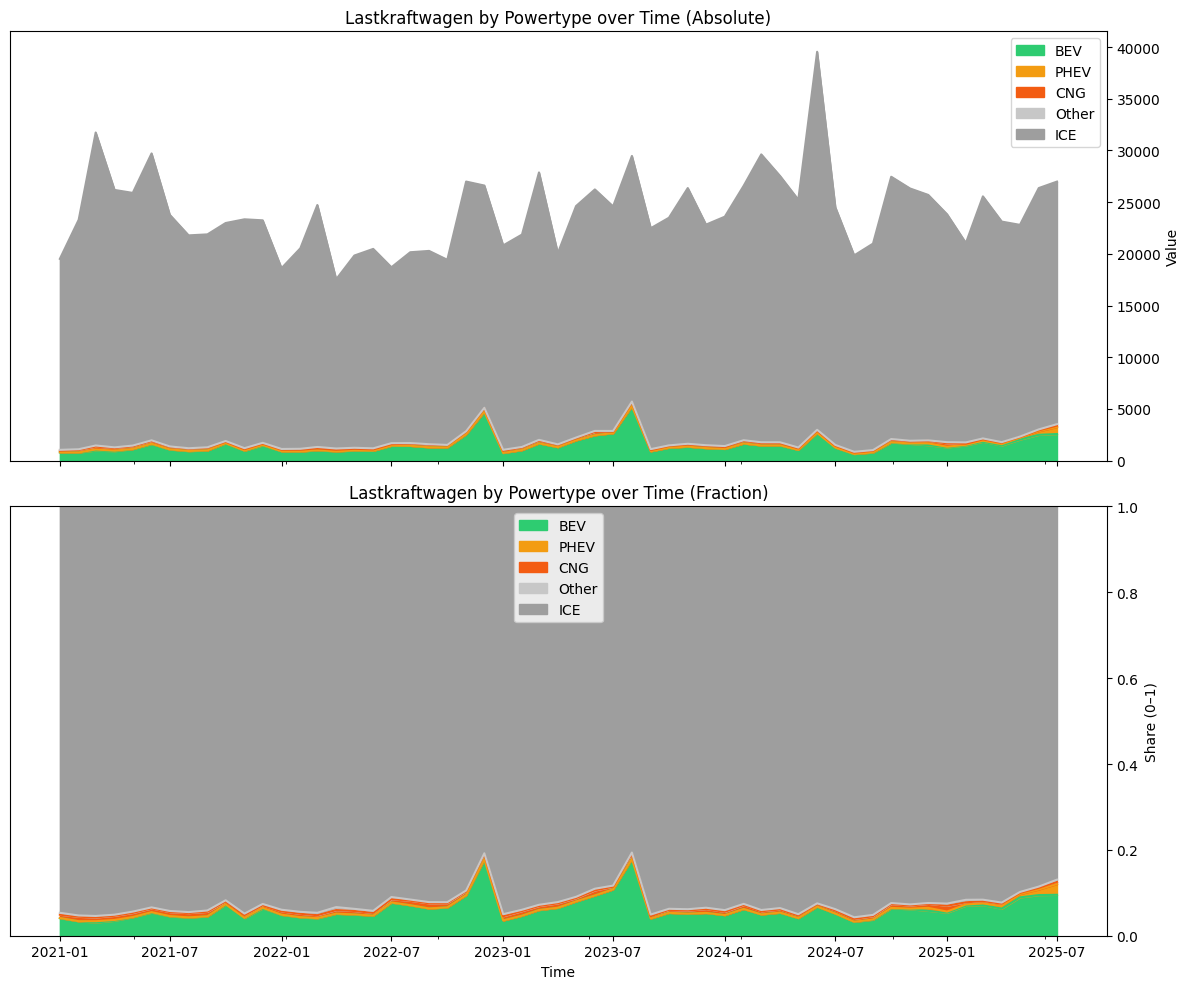

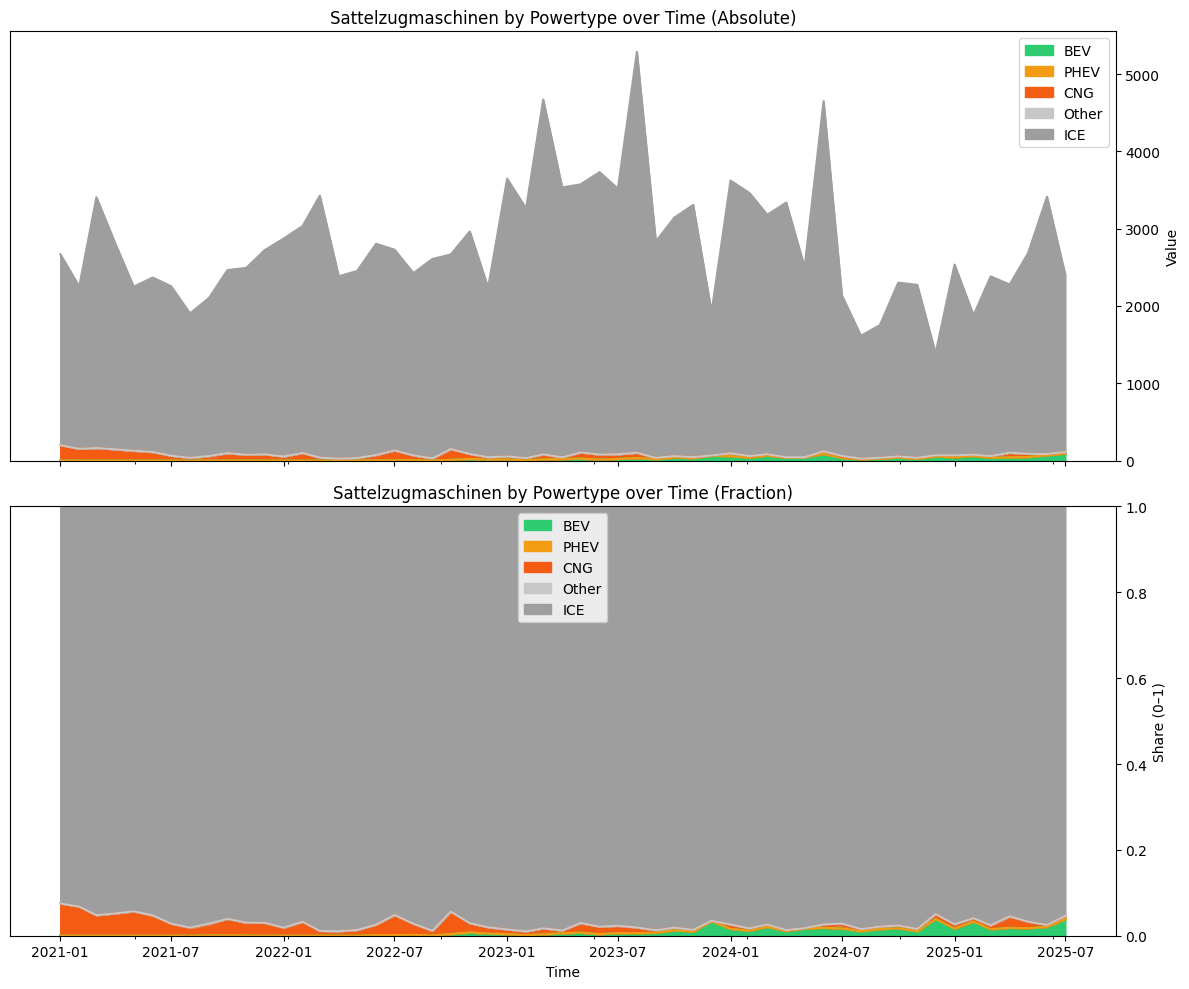

In [4]:

def plot_by_power_type(kfztype):
    order = ['BEV', 'PHEV', 'CNG', 'Other', 'ICE']
    colors = {
        'BEV': '#2ecc71',  # green
        'PHEV': '#f39c12',  # orange
        'CNG': '#f35c12',  # orange
        'Other': '#c7c7c7', # dark grey
        'ICE': '#9e9e9e' # grey
    }

    df_plot = ev_data.xs(kfztype, axis=1, level=0, drop_level=True).sort_index()

    get_name = lambda c: getattr(c, 'value', str(c))
    names = {c: get_name(c) for c in df_plot.columns}

    other_cols = [c for c, n in names.items() if n not in {'BEV', 'PHEV', 'ICE', 'CNG'}]

    df_plot2 = pd.DataFrame({
        'BEV': df_plot[PowerType.BEV],
        'PHEV': df_plot[PowerType.PHEV],
        'CNG': df_plot[PowerType.CNG],
        'Other': df_plot[other_cols].sum(axis=1) if other_cols else 0,
        'ICE': df_plot[PowerType.ICE],
    }).reindex(columns=order)

    df_share2 = df_plot2.div(df_plot2.sum(axis=1), axis=0)

    color_list = [colors[k] for k in order]

    fig2, axes2 = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    df_plot2.plot(kind='area', stacked=True, ax=axes2[0], color=color_list)
    axes2[0].set_title(f'{kfztype} by Powertype over Time (Absolute)')
    axes2[0].set_ylabel('Value')
    axes2[0].yaxis.set_label_position("right")
    axes2[0].yaxis.tick_right()

    df_share2.plot(kind='area', stacked=True, ax=axes2[1], color=color_list)
    axes2[1].set_title(f'{kfztype} by Powertype over Time (Fraction)')
    axes2[1].set_xlabel('Time')
    axes2[1].set_ylabel('Share (0–1)')
    axes2[1].set_ylim(0, 1)
    axes2[1].yaxis.set_label_position("right")
    axes2[1].yaxis.tick_right()

    plt.tight_layout()
    plt.show()

plot_by_power_type('Lastkraftwagen')
plot_by_power_type('Sattelzugmaschinen')

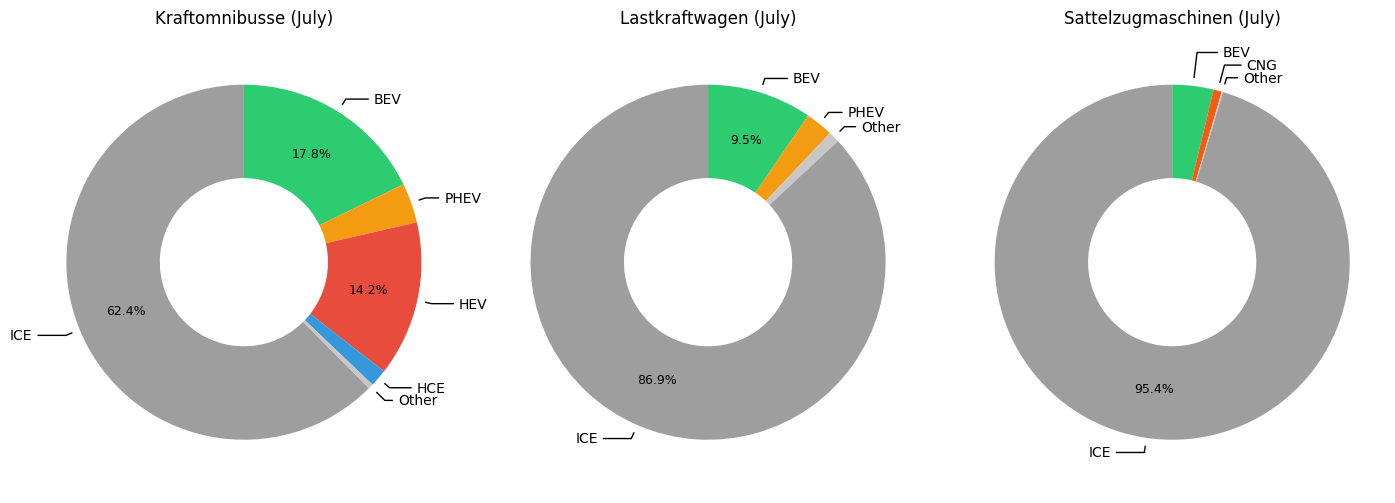

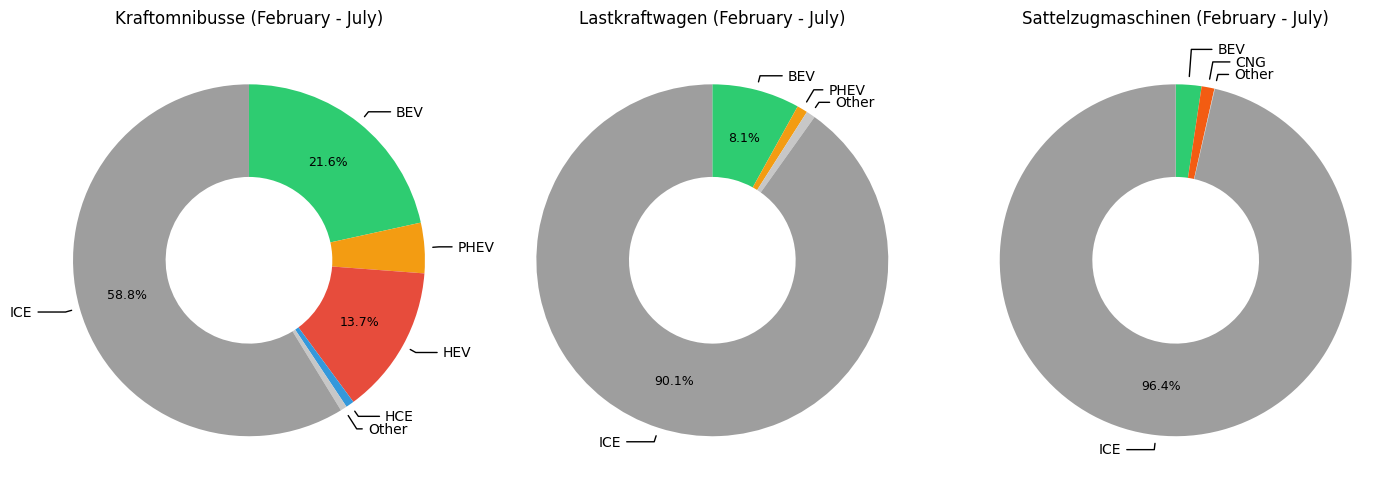

In [5]:
# Pie charts of average fuel-type shares over specific months (e.g., "april - june")
n_months = 6
vehicle_types = ['Kraftomnibusse', 'Lastkraftwagen', 'Sattelzugmaschinen']

# Default display order and colors (can contain all fuel types; "Other" will be added/updated dynamically)
order = ['BEV', 'PHEV', 'FCEV', 'HEV', 'HCE', 'CNG', 'Other', 'ICE']
colors = {
    'BEV': '#2ecc71',
    'PHEV': '#f39c12',
    'FCEV': '#3498db',
    'HEV': '#e74c3c',
    'HCE': '#3498db',
    'CNG': '#f35c12',
    'Other': '#c7c7c7',
    'ICE': '#9e9e9e'
}


def plot_fuel_share_pie(ax, vtype, n_months=3, others_threshold=0.005, order=order, colors=colors):
    sub = ev_data.xs(vtype, axis=1, level=0, drop_level=True).sort_index()

    # Map Enum columns to string names once
    get_name = lambda c: getattr(c, 'value', str(c))
    name_map = {c: get_name(c) for c in sub.columns}
    df_named = sub.rename(columns=name_map)

    # Aggregate in case multiple columns map to the same name
    df_named = df_named.T.groupby(level=0).sum().T

    # Ensure numeric float dtype
    df_named = df_named.apply(pd.to_numeric, errors='coerce').astype('float64')

    # Compute monthly shares, then average over the last n months
    df_share = df_named.div(df_named.sum(axis=1), axis=0).fillna(0.0)
    if isinstance(df_share.index, pd.DatetimeIndex):
        recent = df_share.last(f'{n_months}M')
    else:
        recent = df_share.tail(n_months)

    avg_share = recent.mean(axis=0).fillna(0.0)

    # Dynamically group categories below threshold into "Other"
    small_cats = [k for k, v in avg_share.items() if k != 'Other' and v < others_threshold]
    if small_cats:
        other_value = avg_share.get('Other', 0.0) + float(avg_share[small_cats].sum())
        avg_share = avg_share.drop(index=small_cats)
        if other_value > 0:
            avg_share['Other'] = other_value

    # If no data or all zeros, hide this plot
    if avg_share.sum() <= 0:
        ax.axis('off')
        ax.set_title(f'{vtype}: No data')
        return

    # Reorder according to desired order, then append any remaining categories
    ordered_keys = [k for k in order if k in avg_share.index] + [k for k in avg_share.index if k not in order]
    avg_share = avg_share[ordered_keys]

    # Build a color map with fallbacks
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', [])
    color_map = dict(colors)
    cc_idx = 0
    for k in avg_share.index:
        if k not in color_map:
            fallback = color_cycle[cc_idx % len(color_cycle)] if color_cycle else '#aaaaaa'
            color_map[k] = fallback
            cc_idx += 1

    draw_pie(
        ax=ax,
        values=avg_share.values,
        labels=avg_share.index.tolist(),
        colors_map=color_map,
        autopct_threshold=0.05,
        startangle=90,
        counterclock=False,
        pctdistance=0.72,
        radius=0.95,
        label_line_radius=0.98,
        label_radius=1.05,
        label_vertical_aligned=False,
        text_fontsize=9,
        show=False
    )

    start_m = recent.index.min().strftime('%B')
    end_m = recent.index.max().strftime('%B')
    months_label = start_m if start_m == end_m else f'{start_m} - {end_m}'

    ax.set_title(f'{vtype} ({months_label})')
    ax.margins(0.1,0.15)
    ax.axis('scaled')



# Plot all vehicle types in one figure for last month
fig, axes = plt.subplots(1, len(vehicle_types), figsize=(4 * len(vehicle_types) + 2, 6))
if len(vehicle_types) == 1:
    axes = [axes]

for ax, vt in zip(axes, vehicle_types):
    plot_fuel_share_pie(ax, vt, n_months=1)

plt.tight_layout()
plt.show()

# Plot all vehicle types for the last n months
fig, axes = plt.subplots(1, len(vehicle_types), figsize=(4 * len(vehicle_types) + 2, 6))
if len(vehicle_types) == 1:
    axes = [axes]

for ax, vt in zip(axes, vehicle_types):
    plot_fuel_share_pie(ax, vt, n_months=n_months)

plt.tight_layout()
plt.show()


### Other Stuff

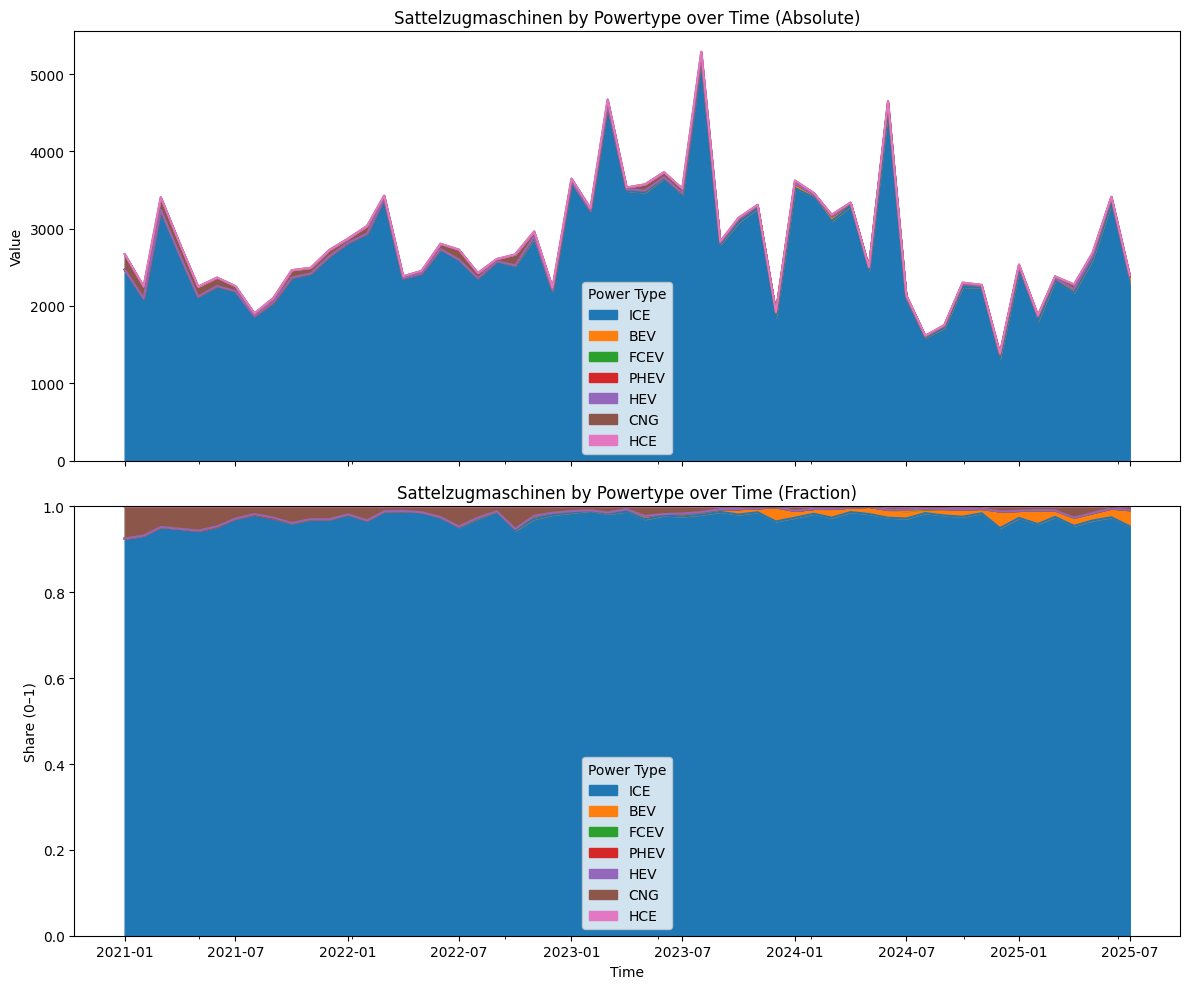

In [6]:
#kfztype = 'Lastkraftwagen'
kfztype = 'Sattelzugmaschinen'

df_plot = ev_data.xs(kfztype, axis=1, level=0, drop_level=True).sort_index()
df_share = df_plot.div(df_plot.sum(axis=1), axis=0)

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

df_plot.plot(kind='area', stacked=True, ax=axes[0])
axes[0].set_title(f'{kfztype} by Powertype over Time (Absolute)')
axes[0].set_ylabel('Value')

df_share.plot(kind='area', stacked=True, ax=axes[1])
axes[1].set_title(f'{kfztype} by Powertype over Time (Fraction)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Share (0–1)')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()
